**1. Comparing linear and non-linear DR (4 points)
Compare PCA and t-SNE methods by visualizing Bike Sharing Rental dataset. Explore how the different features are shown in the DR components. Build a simple prediction model (for example, MLP or Random Forest) to predict the count of total rental bikes and compare the performance of the model with the different DR techniques.**

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import arff
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Load data
data, meta = arff.loadarff('dataset.arff')
df = pd.DataFrame(data)
df = df.apply(lambda col: col.map(lambda x: x.decode() if isinstance(x, bytes) else x))

# Convert categorical string columns to numeric
for col in df.columns:
    if df[col].dtype == object:
        df[col] = pd.Categorical(df[col]).codes
 
# X = features, y = target        
X = df.drop(columns=['count'])
y = df['count']
print(df.columns)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Index(['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weather', 'temp', 'feel_temp', 'humidity', 'windspeed', 'casual',
       'registered', 'count'],
      dtype='object')


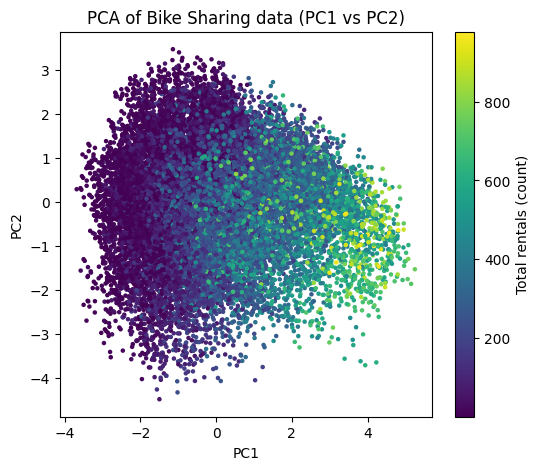

PCA loadings:
                 PC1       PC2
season     -0.186350 -0.107155
year        0.110860 -0.100140
month       0.081012  0.303310
hour        0.244702 -0.275031
holiday    -0.012551 -0.082030
weekday     0.014474 -0.020940
workingday -0.016847  0.145891
weather    -0.166443  0.246907
temp        0.482092  0.353593
feel_temp   0.476836  0.368462
humidity   -0.242825  0.522166
windspeed   0.061597 -0.381598
casual      0.434440 -0.149216
registered  0.383283 -0.141790


In [17]:
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='viridis', s=5)
plt.title('PCA of Bike Sharing data (PC1 vs PC2)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Total rentals (count)')
plt.show()

# PCA loadings
loadings = pd.DataFrame(pca.components_.T, columns=['PC1','PC2'], index=df.drop(columns=['count']).columns)
print("PCA loadings:")
print(loadings)

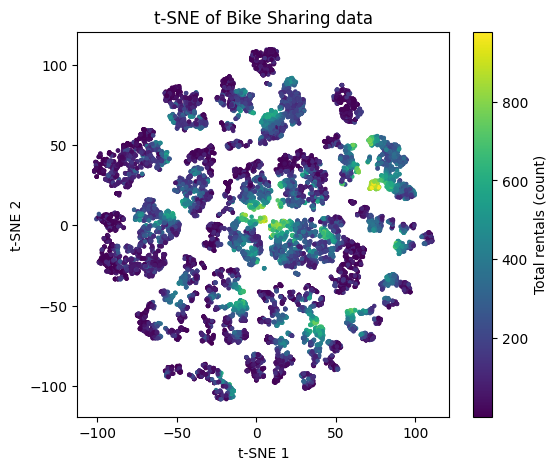

In [18]:
# t-SNE
tsne = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, cmap='viridis', s=5)
plt.title('t-SNE of Bike Sharing data')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(label='Total rentals (count)')
plt.show()

In [19]:
# train/test Split = 0.7/0.3
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
Xp_train, Xp_test, yp_train, yp_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)
Xt_train, Xt_test, yt_train, yt_test = train_test_split(X_tsne, y, test_size=0.3, random_state=42)

# Random Forest Models:

# - Baseline (no dimensionality reduction)
rf_base = RandomForestRegressor(random_state=42)
rf_base.fit(X_train, y_train)
y_pred_base = rf_base.predict(X_test)

# - PCA model
rf_pca = RandomForestRegressor(random_state=42)
rf_pca.fit(Xp_train, yp_train)
y_pred_pca = rf_pca.predict(Xp_test)

# - t-SNE model
rf_tsne = RandomForestRegressor(random_state=42)
rf_tsne.fit(Xt_train, yt_train)
y_pred_tsne = rf_tsne.predict(Xt_test)

# Evaluation
print("\nModel Performance Comparison:")

print("\nBaseline:")
print("  R2:", r2_score(y_test, y_pred_base))
print("  RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_base)))

print("\nPCA:")
print("  R2:", r2_score(yp_test, y_pred_pca))
print("  RMSE:", np.sqrt(mean_squared_error(yp_test, y_pred_pca)))

print("\nt-SNE:")
print("  R2:", r2_score(yt_test, y_pred_tsne))
print("  RMSE:", np.sqrt(mean_squared_error(yt_test, y_pred_tsne)))


Model Performance Comparison:

Baseline:
  R2: 0.9998099803600529
  RMSE: 2.4500775881501196

PCA:
  R2: 0.594598017977882
  RMSE: 113.16797011620592

t-SNE:
  R2: 0.9309497314692672
  RMSE: 46.70498943361258


Using all features in the baseline model, no information is lost and so random forest can near perfectly model the rentals.

PCA is much worse because only 2 principal components were retained causing significant information loss.

t-SNE also uses 2 principal components, but preserves local relationships between similar samples. This keeps important patterns about hours, weather, and seasons, allowing the model to predict better than PCA despite the low dimensionality.